 # Import Packages and Dataset

In [1]:
# Import libraries 
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import f1_score,precision_score
from PIL import Image
from torchvision.transforms import transforms 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from pathlib import Path
import math
import copy

In [2]:
# Get Dataset
image_path='../input/celeba-dataset/img_align_celeba/img_align_celeba'
df_attr=pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
df_landmarks=pd.read_csv('../input/celeba-dataset/list_landmarks_align_celeba.csv')
df_bbox=pd.read_csv('../input/celeba-dataset/list_bbox_celeba.csv')
df_attr.head()
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


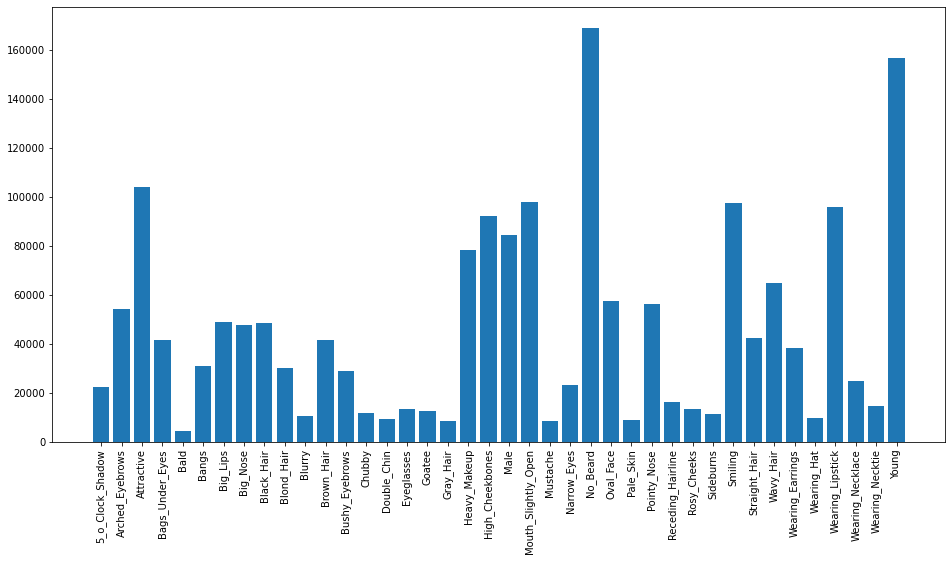

In [3]:
# Visualize Label count of Dataset and check for imbalance
arr=pd.DataFrame(df_attr.iloc[:,1:].sum(axis=0))
arr.columns=['labels']
arr.sort_values(by='labels',ascending=False)
plt.figure(figsize=(16,8))
plt.bar(arr.index,arr['labels'])
plt.xticks(rotation=90)
plt.show()

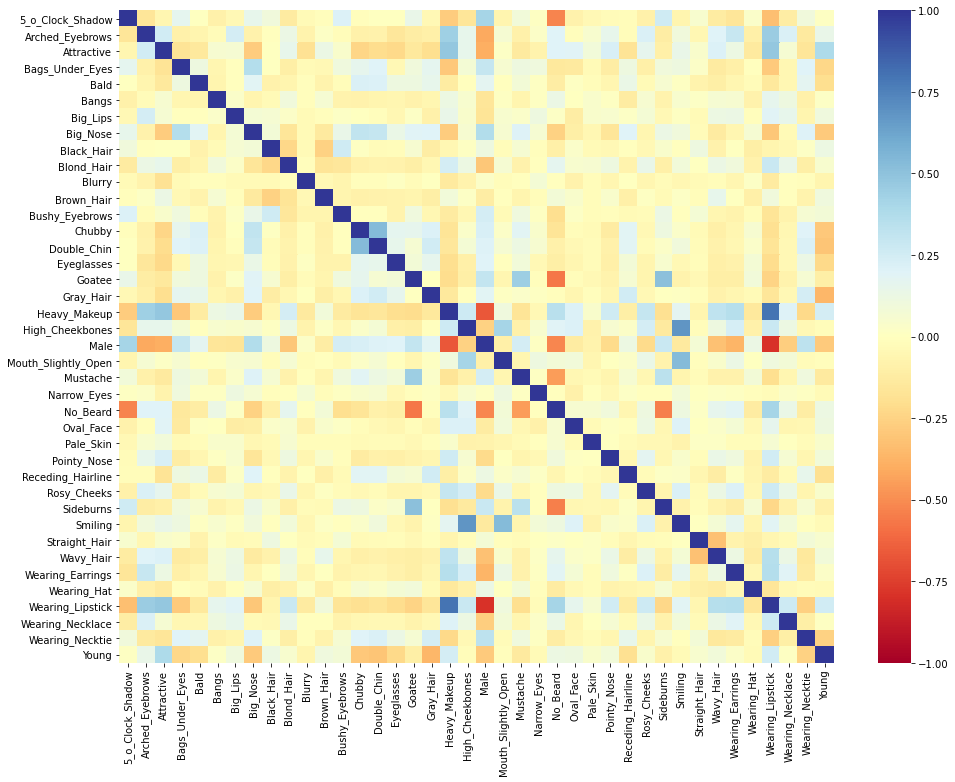

In [4]:
# Look for correlation between labels
import seaborn as sns
plt.figure(figsize=(16,12))
sns.heatmap(df_attr.iloc[:,1:].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

# DataLoader 

In [5]:
# Class to get data in specific format and preprocessing.
class CelebDataset(Dataset):
    def __init__(self,df_1,image_path,transform=None,mode='train'):
        super().__init__()
        self.attr=df_1.drop(['image_id'],axis=1)
        self.path=image_path
        self.image_id=df_1['image_id']
        self.transform=transform
        self.mode=mode
    def __len__(self):
        return self.image_id.shape[0]
    def __getitem__(self,idx:int):
        image_name=self.image_id.iloc[idx]
        image=Image.open(os.path.join(image_path,image_name))
        attributes=np.asarray(self.attr.iloc[idx].T,dtype=np.float32)
        if self.transform:
            image=self.transform(image)
        return image,attributes    

In [6]:
# Split Dataset into train,test and valid
from sklearn.model_selection import train_test_split
train_df,test=train_test_split(df_attr,test_size=0.1,shuffle=True,random_state=212)
valid_df,test_df=train_test_split(test,test_size=0.5,random_state=212)
train_df.shape,valid_df.shape,test_df.shape

((182339, 41), (10130, 41), (10130, 41))

In [7]:
# Apply Data augmentation and different type of transforms on train data.
train_transform=transforms.Compose([transforms.Resize((224,224)),transforms.RandomVerticalFlip(p=0.5),
                                    transforms.RandomHorizontalFlip(p=0.5),transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5063, 0.4258, 0.3832],std=[0.2644, 0.2436, 0.2397])])
# Apply Data augmentation and different type of transforms on test and validation data.
valid_transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5063, 0.4258, 0.3832],std=[0.2644, 0.2436, 0.2397])])

In [8]:
# Create Dataset Object and DataLoader for train and validation set 
train_data=CelebDataset(train_df,image_path,train_transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,num_workers=4)
valid_data=CelebDataset(valid_df,image_path,valid_transform)
valid_loader=DataLoader(valid_data,batch_size=64,num_workers=4)

# Visualizing Data

In [9]:
# function to visualize dataset
def imshow(images,attr,idx:int):
    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()

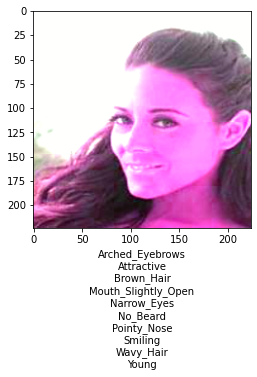

In [10]:
# Visualizing Data
images,attr=next(iter(train_loader))
imshow(images,attr,0)

# Creating Model

In [11]:
# Defining Class for Single Layer. 
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
        super(Layer,self).__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
        self.bn=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        nn.init.xavier_uniform_(self.conv.weight)
    def forward(self,Input):
        output=self.conv(Input)
        output=self.bn(output)
        output=self.relu(output)
        return output

In [12]:
# Complete model
class CelebModel(nn.Module):
    def __init__(self,num_classes=40):
        super(CelebModel,self).__init__()
        
        self.unit1=Layer(in_ch=3,out_ch=32)        
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
        self.drop2=nn.Dropout(0.5)   
        
        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        
        self.pool5=nn.AvgPool2d(kernel_size=2)
        
        self.drop3=nn.Dropout(0.5)
        
        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)
        
        self.fc=nn.Linear(in_features=512,out_features=num_classes)
        
    def forward(self,Input):
        
        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)
        
        return output

In [13]:
# setting environment 
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Creating Model Object,loss function,optimizer and scheduler
model=CelebModel().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
scheduler=optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000001, max_lr=1,mode='exp_range')

# Training and Validating Model

In [15]:
# Creating a Checkpoint to Save model
def Save_model(model,cur_acc,best_acc,filename):
    if cur_acc>best_acc:
        best_acc=cur_acc
        best_model=copy.deepcopy(model)
        torch.save(best_model,filename)
    return best_acc

In [16]:
# Create validation loop 
def val_model():
    model.eval()
    epoch_loss=0
    acc=0
    with torch.no_grad():
        val_pred=[]
        val_lbl=[]
        for images,attr in valid_loader:
            
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            val_lbl.append(attr.detach().cpu())
            
            val_pred.append(prediction.detach().cpu()) 
            
        epoch_loss/=len(valid_data)
        
        acc=f1_score(torch.cat(val_lbl,dim=0).numpy(),torch.cat(val_pred,dim=0).numpy(),average='samples')
        
        return epoch_loss,acc    

In [17]:
# Create Training loop 
def train_model(num_epochs):
    train_loss=[]
    best_acc=0.0
    for i in range(num_epochs):
        epoch_loss=0
        acc=0
        j=0
        epoch_pred=[]
        epoch_lbl=[]
        model.train()
        for images,attr in train_loader:
            j+=1 
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            optimizer.zero_grad()
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            loss.backward()
            
            optimizer.step()
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            epoch_lbl.append(attr.detach().cpu())
            
            epoch_pred.append(prediction.detach().cpu()) 
            
            torch.cuda.empty_cache()
            
            if (j+1)%500==0:
                print(f'Loss #{(j+1)//500}:{loss.item()}')
            
            scheduler.step()
            
        epoch_loss/=len(train_data)
        
        acc=f1_score(torch.cat(epoch_lbl,dim=0).numpy(),torch.cat(epoch_pred,dim=0).numpy(),average='samples')
        
        train_loss.append(epoch_loss)
        
        val_loss,val_acc=val_model()
        
        best_acc=Save_model(model,val_acc,best_acc,'model.pth')   # save model
        
        print(f'Epoch : {i+1} , Training loss:{epoch_loss} , Training f1_score:{acc} , Validation loss:{val_loss} , Validation f1_score:{val_acc}')

In [18]:
# Training model
num_epochs=7
if __name__=='__main__':
    train_model(num_epochs)

Loss #1:0.32143378257751465
Loss #2:0.27580997347831726
Loss #3:0.25906917452812195
Loss #4:0.25587382912635803
Loss #5:0.24146771430969238
Epoch : 1 , Training loss:0.28288575613380157 , Training f1_score:0.6641240479333884 , Validation loss:0.22880753938619852 , Validation f1_score:0.7288084232374481


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CelebModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Layer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss #1:0.2291232794523239
Loss #2:0.21703210473060608
Loss #3:0.22653809189796448
Loss #4:0.2359209507703781
Loss #5:0.23642373085021973
Epoch : 2 , Training loss:0.229160738312567 , Training f1_score:0.7354782225979964 , Validation loss:0.22576760302232496 , Validation f1_score:0.7404074720589193
Loss #1:0.21733930706977844
Loss #2:0.22615952789783478
Loss #3:0.22871354222297668
Loss #4:0.23896761238574982
Loss #5:0.22508151829242706
Epoch : 3 , Training loss:0.22125480446927992 , Training f1_score:0.7465938522972817 , Validation loss:0.20813526816276312 , Validation f1_score:0.7687931701069434
Loss #1:0.19874171912670135
Loss #2:0.213889941573143
Loss #3:0.23165582120418549
Loss #4:0.23024597764015198
Loss #5:0.2183331996202469
Epoch : 4 , Training loss:0.21779951556849136 , Training f1_score:0.7512637226270453 , Validation loss:0.19960206138063866 , Validation f1_score:0.7754634217800934
Loss #1:0.20478136837482452
Loss #2:0.2211102992296219
Loss #3:0.21540628373622894
Loss #4:0.22

# Testing Model

In [19]:
# Create Dataset Object and DataLoader for train and validation set
test_data=CelebDataset(test_df,image_path,valid_transform)
test_loader=DataLoader(test_data,batch_size=64,shuffle=False,num_workers=4)

In [20]:
# Function to predict Labels
def Predict(images,model,idx:int):
    pred=model(images)
    images=images.cpu().numpy().transpose((0,2,3,1))
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2, 1)
    plt.imshow(images[idx])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    attr=torch.round(torch.sigmoid(pred)).cpu().detach()
    prd=torch.sigmoid(pred[idx]).cpu().detach().numpy()
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    pred_list=[p for p,a in list(zip(prd,att)) if a==1]
    plt.subplot(1,2,2)
    plt.barh(labels,pred_list)
    plt.show()
    return labels

In [21]:
# Loading Save model
model=torch.load('model.pth',map_location=torch.device('cpu'))
model=model.eval()

In [ ]:
# Testing Model
images,attr=next(iter(test_loader))

# Getting actual labels
labels=df_attr.columns.tolist()
labels=labels[1:]
act_labels=[l for l,a in zip(labels,attr[20].numpy()) if a==1]


# Making prediction on test dataset
pred_labels=Predict(images,model,12)


print('Labels:',act_labels)
print('Predictions:',pred_labels)